# N-body Simulation of Dust–Gas Interactions

This project simulated the gravitational collapse of a dust cloud in the presence of a central star and a pre-formed gas disk. Dust particles were initialized with random positions in space and allowed to enter the gas disk at different orbital radii and inclinations. Within the disk, they experienced drag forces from the surrounding gas, causing them to lose energy and gradually settle into the disk. Over time, this process led to the formation of a dust disk embedded within the gas disk.  

This simulation is made using [REBOUND](https://rebound.readthedocs.io/en/latest/)  

For a theoretical background refer: [https://arxiv.org/pdf/2312.13287](https://arxiv.org/pdf/2312.13287)

In [1]:
import numpy as np
import rebound
import matplotlib.pyplot as plt
import astropy.constants as cnst
from astropy import units
from tqdm.auto import tqdm
from mpl_toolkits.mplot3d import Axes3D

### Physical Constants:

Here we define the gas properties and dust grain parameters:
- The gas isothermal sound speed depends on temperature.
- Dust is treated as compact grains with radius `a_g`.
- Their stopping time (drag timescale) will depend on the local gas density and velocity.

Note: The units throughout the code will in the CGS system.

In [2]:
k_b = cnst.k_B.cgs.value         # Boltzmann constant [erg/K]
mu = 2.3                         # Mean molecular weight (H2 + He mix)
m_p = cnst.m_p.cgs.value         # Proton mass [g]
cs_constant = np.sqrt(k_b / (mu * m_p))   # Prefactor for sound speed [cm/s/sqrt(K)]

GM_constant = (cnst.G * cnst.M_sun).cgs.value  # GM of Sun [cm^3/s^2]
M_sun_cgs = cnst.M_sun.cgs.value               # Solar mass [g]
au_constant = cnst.au.cgs.value                # Astronomical unit [cm]

rho_s = 1.6     # Internal density of dust grain [g/cm^3]
a_g = 1e-4      # Dust grain radius [cm]
m_cgs = 4 * np.pi / 3 * rho_s * a_g**3  # Dust grain mass [g]

### Gas Model

- Cylindrical radius R is used (distance from star in the midplane).  
- A floor of 0.1 AU avoids singularities close to the star.
- The temperature decreases outward ∝ $1/\sqrt{R}$, a typical assumption for protoplanetary disks.
- From this, the gas sound speed and thermal velocity are derived.
- `Omega_k`: orbital angular frequency at radius R.
- `h_g`: vertical thickness of the gas disk.
- `v_k`: circular orbital velocity.
- Because of gas pressure support, gas rotates slightly slower than Keplerian.
- Dust particles thus feel a headwind and lose angular momentum.
- Vertical gas density profile is assumed Gaussian.
- Inside 0.1 AU, density is artificially suppressed.
- `t_stop` = time for drag to significantly alter dust velocity.

Note: the gas model is in cylindrical units and the simulation is in cartesian coordinates. We will frequently be tranforming between them.

In [3]:
def compute_values(data):
    x = data[:, 0]
    y = data[:, 1]
    z = data[:, 2]

    R = np.sqrt(x**2 + y**2)
    R = np.maximum(R, 0.1)  # prevent divergence near star

    #Disk Properties:    
    T = 200 / np.sqrt(R)              # Radial temperature profile [K]
    c_s = cs_constant * np.sqrt(T)    # Sound speed [cm/s]
    v_th = np.sqrt(8/np.pi) * c_s     # Thermal velocity [cm/s]
    
    Omega_k = np.sqrt(GM_constant / (R * au_constant)**3)   # Kepler frequency [s^-1]
    h_g = c_s / Omega_k                                    # Disk scale height [cm]
    v_k = R * au_constant * Omega_k                        # Keplerian velocity [cm/s]

    sqrt_term = 1 + (h_g / (R * au_constant))**2 * (-11/4)
    sqrt_term = np.maximum(sqrt_term, 0)
    v_g = v_k * np.sqrt(sqrt_term) #cm/s
    
    Sigma_g = 200 / R   # Surface density profile [g/cm^2]
    rho_g = (Sigma_g / (np.sqrt(2*np.pi) * h_g)) * np.exp(-(z*au_constant)**2/(2*h_g**2))

    rho_g = np.where(np.sqrt(x**2 + y**2) <= 0.1, 1e-40, rho_g)  # no density inside 0.1 AU

    rho_g = np.maximum(rho_g, 1e-20)     # g/cm^3 minimum density
    v_th  = np.maximum(v_th, 1e-5)       # cm/s minimum thermal velocity

    t_stop = (rho_s * a_g) / (rho_g * v_th)  # stopping time [s]
    return v_g, t_stop, Omega_k

### Simulation Units

All REBOUND calculations are in AU, yr, $M_\odot$, so we pre-compute conversion factors for velocities and times.

In [4]:
t_unit = (1. * units.year).cgs.value
r_unit = au_constant
v_unit = r_unit / t_unit

### Gas Drag

- Compute local gas velocity in Cartesian coordinates.
- For each dust particle, compute relative velocity (v_dust - v_gas).
- Acceleration is added to each particle due to drag.

In [5]:
#Defining the Gas Drag
def gas_drag(reb_sim): #add reb_sim.particles
    ps = sim.particles
    data = np.array([[p.x, p.y, p.z, p.vx, p.vy, p.vz, p.m] for p in sim.particles[1:]])
    phi = np.arctan2(data[:, 1], data[:, 0])
    # compute v_g and t_stop array here
    v_g, t_stop, *_ = compute_values(data)
    t_stop /= t_unit
    v_g /= v_unit
    
    v_g_x = - v_g * np.sin(phi)
    v_g_y =   v_g * np.cos(phi)
    v_g_z = 0.0    #Zero Vertical velocity of Gas
    
    ax = - (data[:, 3] - v_g_x) / t_stop 
    ay = - (data[:, 4] - v_g_y) / t_stop
    az = - (data[:, 5] - v_g_z) / t_stop
    
    for i in range(1,sim.N):
        ps[i].ax += ax[i - 1] 
        ps[i].ay += ay[i - 1]
        ps[i].az += az[i - 1]

### Simulation Setup
- Adds a solar-mass star at the origin.
- Dust particles are initialized in a spherical cloud of radius ~30 AU
- Random sampling ensures uniform 3D distribution of particles.
- Velocities are initialized roughly in circular motion, so dust can interact with gas.
- Center-of-mass shift applied.
- Only the star is gravitating, dust are test particles influenced by gravity + drag.
- `bs` integrator (Bulirsch–Stoer) is chosen for high accurac

In [6]:
def setup_sim(num_particles=10, radius=30):

    #np.random.seed(234657)

    sim = rebound.Simulation()
    sim.units = ('AU', 'yr', 'Msun')
    sim.add(m=1) #Central Star
    for _ in range(num_particles):
        r = radius * np.cbrt(np.random.uniform(0, 1))  
        theta = np.arccos(1 - 2 * np.random.uniform(0, 1))  
        phi = np.random.uniform(0, 2 * np.pi)  
            
        x = r * np.sin(theta) * np.cos(phi)
        y = r * np.sin(theta) * np.sin(phi)
        z = r * np.cos(theta)
    
        vk_out = 2 * np.pi / np.sqrt(radius)
        R = np.sqrt(x**2 + y**2)
    
        vphi = R * vk_out / radius
            
        vx = -np.sin(phi) * vphi
        vy = np.cos(phi) * vphi
        vz = 0
        
        sim.add(m = m_cgs / M_sun_cgs, x=x, y=y, z=z, vx=vx, vy=vy)
    
    sim.move_to_com()
    sim.N_active = 1
    sim.additional_forces = gas_drag
    sim.force_is_velocity_dependent = 1
    sim.integrator = "bs"
    return sim

### Integration Loop
- Integration over 10 years.
- At each step, store dust particle positions, orbital periods, vertical velocity/acceleration, and inclination.
- Output is saved for later plotting.

In [7]:
sim = setup_sim()

N_steps = 100 #Number of steps
t_max = 40 #Integration time in years
time = np.linspace(0, t_max, N_steps)

avg_heights= []
pos = []
num_orbits = []

for t in tqdm(time):
    sim.integrate(t)
    particles = sim.particles[1:]  # exclude central object
    pos.append([[p.x, p.y, p.z, p.P, p.vz, p.az, p.inc] for p in particles])

pos = np.array(pos)

  0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\rebound\simulation.py:259: RuntimeWarning: At least one test particle (type 0) has finite mass. This might lead to unexpected behaviour. Set testparticle_hidewarnings=1 to hide this warning.
  warnings.warn(msg[1:], RuntimeWarning)


### Diagnostics and Plots
- Time vs height: shows how dust settles toward the midplane.
- Orbits vs height: tracks how many orbits pass before settling.
- Velocity & acceleration: quantify damping by gas drag.
- Inclination: decreases over time as particles align with disk plane.
- Semi-major axis: indicates whether particles drift inward.

In [8]:
avg_P = []
num_orb = []
T_stop = []
Omega_K = []

avg_P = np.mean(1 / pos[:,:,3], axis = 1)

for t in time:
    num_orb.append(t*avg_P[int(t)])

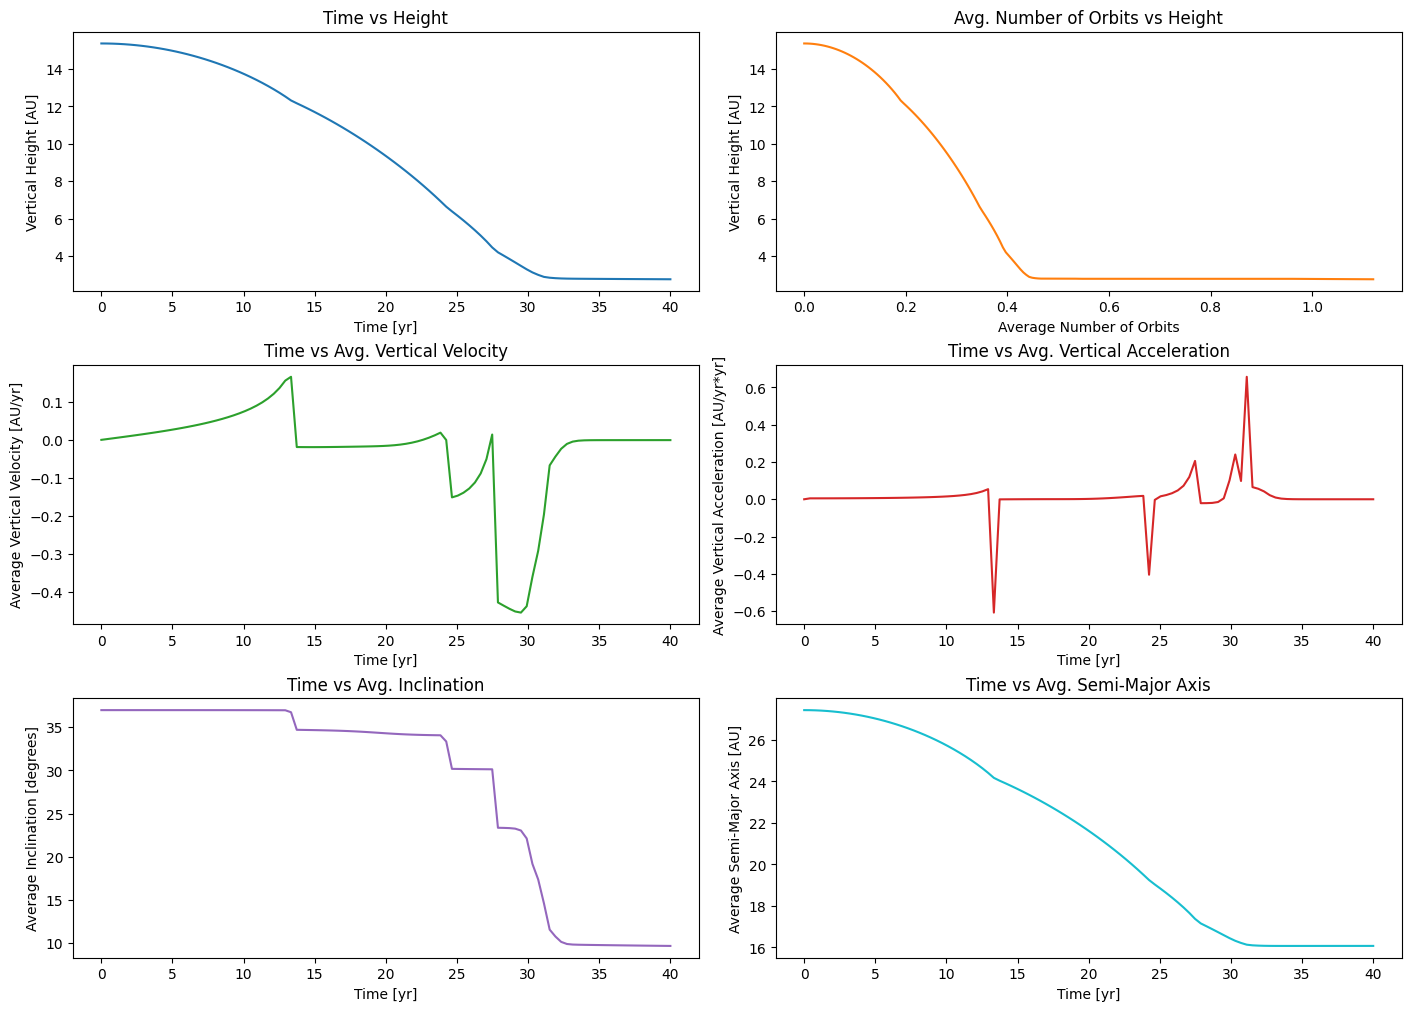

In [9]:
fig, axes = plt.subplots(3, 2, figsize=(14, 10), constrained_layout=True)  # 3 rows, 2 columns
axes = axes.flatten()  
ax1, ax2, ax3, ax4, ax5, ax6 = axes

ax1.plot(time, np.mean(np.abs(pos[:,:,2]), axis=1), color='#1f77b4')
ax1.set_title("Time vs Height")
ax1.set_xlabel("Time [yr]")
ax1.set_ylabel("Vertical Height [AU]")

ax2.plot(num_orb, np.mean(np.abs(pos[:,:,2]),axis=1), color='#ff7f0e')
ax2.set_title("Avg. Number of Orbits vs Height")
ax2.set_xlabel("Average Number of Orbits")
ax2.set_ylabel("Vertical Height [AU]")

ax3.plot(time, np.mean(pos[:,:,4], axis=1), color ='#2ca02c')
ax3.set_title("Time vs Avg. Vertical Velocity")
ax3.set_xlabel("Time [yr]")
ax3.set_ylabel("Average Vertical Velocity [AU/yr]")

ax4.plot(time, np.mean(pos[:,:,-2], axis=1), color ='#d62728')
ax4.set_title("Time vs Avg. Vertical Acceleration")
ax4.set_xlabel("Time [yr]")
ax4.set_ylabel("Average Vertical Acceleration [AU/yr*yr]")

ax5.plot(time, np.degrees(np.mean(pos[:,:,-1], axis=1)) ,color ='#9467bd')
ax5.set_title("Time vs Avg. Inclination")
ax5.set_xlabel("Time [yr]")
ax5.set_ylabel("Average Inclination [degrees]")

ax6.plot(time, np.mean(np.sqrt(pos[:,:, 0]**2 + pos[:,:, 1]**2 + pos[:,:, 2]**2), axis = 1), color ='#17becf')
ax6.set_title("Time vs Avg. Semi-Major Axis")
ax6.set_xlabel("Time [yr]")
ax6.set_ylabel("Average Semi-Major Axis [AU]")

#plt.savefig("Param_time_40y_10p_whfast.jpg", dpi = 600)
plt.show()

### Plotting Trajectories of Dust Particles in 3D

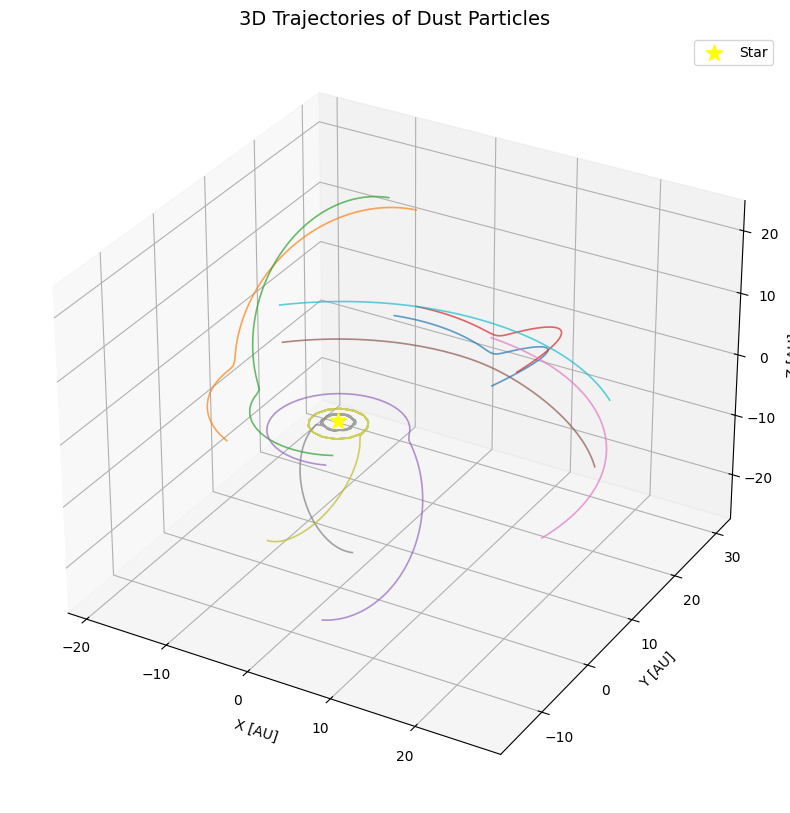

In [10]:
# Extract positions over time
x_all = pos[:, :, 0]   # shape: (N_steps, N_particles)
y_all = pos[:, :, 1]
z_all = pos[:, :, 2]

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")

# Plot each particle trajectory
for i in range(x_all.shape[1]):  
    ax.plot(x_all[:, i], y_all[:, i], z_all[:, i], lw=1.2, alpha=0.7)

# Mark the central star at the origin
ax.scatter(0, 0, 0, color="yellow", s=150, marker="*", label="Star")

# Labels and view
ax.set_title("3D Trajectories of Dust Particles", fontsize=14)
ax.set_xlabel("X [AU]")
ax.set_ylabel("Y [AU]")
ax.set_zlabel("Z [AU]")
ax.legend()

# Optional: set equal aspect ratio
max_range = np.array([x_all.max()-x_all.min(), y_all.max()-y_all.min(), z_all.max()-z_all.min()]).max() / 2.0
mid_x = (x_all.max()+x_all.min()) * 0.5
mid_y = (y_all.max()+y_all.min()) * 0.5
mid_z = (z_all.max()+z_all.min()) * 0.5
ax.set_xlim(mid_x - max_range, mid_x + max_range)
ax.set_ylim(mid_y - max_range, mid_y + max_range)
ax.set_zlim(mid_z - max_range, mid_z + max_range)

plt.show()